In [1]:
import json
import pandas as pd

# Load JSON data
with open('merged_report.json', 'r') as f:
    data = json.load(f)

# Flatten into DataFrame (assuming structure: [{hour: "2025-05-08 12:00", data: [[...], [...], ...]}, ...])
records = []
for entry in data:
    hour = entry['hour']
    for row in entry['data']:
        records.append({'hour': hour, 'values': row})

df = pd.DataFrame(records)

# Show preview
print(df.head())


               hour                          values
0  2025-05-14 05:00   [Time, Domain, Download (kB)]
1  2025-05-14 05:00     [05:59, adguard.com, 0.236]
2  2025-05-14 05:00    [05:59, facebook.com, 0.145]
3  2025-05-14 05:00  [05:59, googleapis.com, 0.337]
4  2025-05-14 05:00     [05:58, adguard.com, 2.082]


In [2]:
# Assuming 'values' is a list like ['Device1', '192.168.1.2', '500MB']
df_expanded = pd.DataFrame(df['values'].tolist(), columns=['Device', 'IP', 'Traffic'])
df_expanded['hour'] = df['hour']

# Show expanded table
print(df_expanded.head())


  Device              IP        Traffic              hour
0   Time          Domain  Download (kB)  2025-05-14 05:00
1  05:59     adguard.com          0.236  2025-05-14 05:00
2  05:59    facebook.com          0.145  2025-05-14 05:00
3  05:59  googleapis.com          0.337  2025-05-14 05:00
4  05:58     adguard.com          2.082  2025-05-14 05:00


In [3]:
import json
import pandas as pd

# Load JSON data
with open('merged_report.json', 'r') as f:
    data = json.load(f)

# Flatten into DataFrame
records = []
for entry in data:
    hour = entry['hour']  # e.g., '2025-05-08 12:00'
    # Assuming row structure like [['192.168.1.1', '500MB']]
    for row in entry['data']:
        records.append({'timestamp': hour, 'traffic': row[-1]})  # Take last column as traffic

df = pd.DataFrame(records)

# Preview data
print(df.head())


          timestamp        traffic
0  2025-05-14 05:00  Download (kB)
1  2025-05-14 05:00          0.236
2  2025-05-14 05:00          0.145
3  2025-05-14 05:00          0.337
4  2025-05-14 05:00          2.082


In [5]:
print(df['traffic'].unique())
print(df)


[]
Empty DataFrame
Columns: [timestamp, traffic, traffic_MB]
Index: []


In [6]:
# Load JSON data
with open('merged_report.json', 'r') as f:
    data = json.load(f)

# Print example to understand actual structure
import pprint
pprint.pprint(data[0], indent=2)


{ 'data': [ ['Time', 'Domain', 'Download (kB)'],
            ['05:59', 'adguard.com', '0.236'],
            ['05:59', 'facebook.com', '0.145'],
            ['05:59', 'googleapis.com', '0.337'],
            ['05:58', 'adguard.com', '2.082'],
            ['05:58', 'googleapis.com', '1.426'],
            ['05:57', 'adguard.com', '1.152'],
            ['05:57', 'googleapis.com', '4.739'],
            ['05:55', 'whatsapp.net', '0'],
            ['05:55', 'facebook.com', '0.145'],
            ['05:55', 'googleapis.com', '8.02'],
            ['05:55', 'linkedin.com', '0.04'],
            ['05:54', 'adguard.com', '2.24']],
  'hour': '2025-05-14 05:00'}


In [7]:
# Print just the first few rows of the first entry's data
pprint.pprint(data[0]['data'][:5], indent=2)


[ ['Time', 'Domain', 'Download (kB)'],
  ['05:59', 'adguard.com', '0.236'],
  ['05:59', 'facebook.com', '0.145'],
  ['05:59', 'googleapis.com', '0.337'],
  ['05:58', 'adguard.com', '2.082']]


In [9]:
import json
import pandas as pd

# Load JSON data
with open('merged_report.json', 'r') as f:
    data = json.load(f)

records = []
for entry in data:
    base_hour = entry['hour']  # e.g., '2025-05-14 05:00'
    for row in entry['data'][1:]:  # Skip header row
        if len(row) >= 3:
            time_str = row[0]  # e.g., '05:59'
            domain = row[1]
            try:
                download_kB = float(row[2])
                full_timestamp = f"{base_hour.split()[0]} {time_str}"
                records.append({
                    'timestamp': full_timestamp,
                    'domain': domain,
                    'download_kB': download_kB
                })
            except ValueError:
                continue  # Skip non-numeric rows

df = pd.DataFrame(records)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M')

# Extract date for filtering later
df['date'] = df['timestamp'].dt.date

# Preview
print(df.head())


            timestamp          domain  download_kB        date
0 2025-05-14 05:59:00     adguard.com        0.236  2025-05-14
1 2025-05-14 05:59:00    facebook.com        0.145  2025-05-14
2 2025-05-14 05:59:00  googleapis.com        0.337  2025-05-14
3 2025-05-14 05:58:00     adguard.com        2.082  2025-05-14
4 2025-05-14 05:58:00  googleapis.com        1.426  2025-05-14


Dropdown(description='Select Date:', index=1, options=(datetime.date(2025, 5, 7), datetime.date(2025, 5, 8), d…

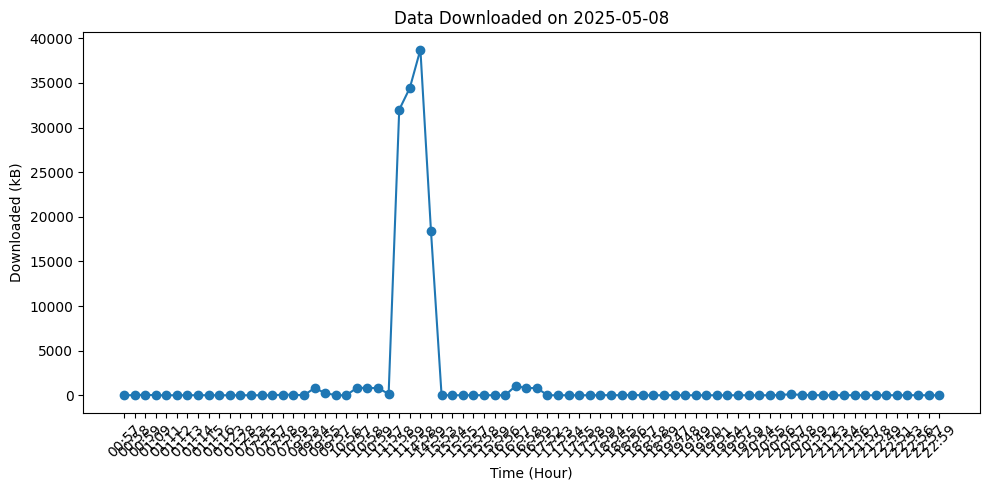

In [11]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a dropdown widget for available dates
date_dropdown = widgets.Dropdown(
    options=sorted(df['date'].unique()),
    description='Select Date:',
)


def on_date_change(change):
    clear_output(wait=True)
    display(date_dropdown)

    selected_date = change['new']
    df_day = df[df['date'] == selected_date]

    # Group by hour and sort to maintain time order
    df_day['hour'] = df_day['timestamp'].dt.strftime('%H:%M')
    hourly_usage = df_day.groupby('hour')['download_kB'].sum().sort_index()

    # Plot as a line chart
    plt.figure(figsize=(10, 5))
    plt.plot(hourly_usage.index, hourly_usage.values, marker='o', linestyle='-')
    plt.title(f'Data Downloaded on {selected_date}')
    plt.xlabel('Time (Hour)')
    plt.ylabel('Downloaded (kB)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Set up the event listener
date_dropdown.observe(on_date_change, names='value')

# Display the widget
display(date_dropdown)


In [13]:
# Display all rows without truncation
pd.set_option('display.max_rows', None)

# Re-run the domain summary to see all domains
print(domain_usage)


domain
googlevideo.com           212139.619
crunchyrollcdn.com         93351.020
gvt1.com                    9883.243
reddit.com                  9006.195
google.com                  4406.569
googleapis.com              3512.577
whatsapp.net                3323.384
redditstatic.com            2844.160
redd.it                     2797.952
redditmedia.com             1857.590
googleusercontent.com       1780.383
tenor.com                   1189.888
gstatic.com                  696.974
adguard.com                  579.147
ytimg.com                    414.446
facebook.com                 377.596
linkedin.com                 313.154
uber.com                     254.877
ggpht.com                    252.315
youtube.com                   89.917
yellow.ai                     82.647
xtracloud.net                 82.378
samsungcloud.com              71.422
vrv.co                        40.872
crunchyroll.com               29.323
openai.com                    24.774
giphy.com                     2